In [1]:
# fragility_train.ipynb
import os, cv2, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

DATA_DIR = r"../Datasets/FragilityLevelDetection"
BATCH = 16
IMG = (224, 224)


In [2]:
def convert_to_rgb(root_dir):
    print("🖼️ Converting grayscale images to RGB (if needed)...")
    for root, _, files in os.walk(root_dir):
        for f in tqdm(files):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, f)
                img = cv2.imread(path)
                if img is None:
                    continue
                if len(img.shape) == 2:  # grayscale
                    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    cv2.imwrite(path, rgb)

convert_to_rgb(DATA_DIR)
print("✅ Conversion done. All images are now 3-channel RGB.")


🖼️ Converting grayscale images to RGB (if needed)...


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 471/471 [00:16<00:00, 28.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 796/796 [00:24<00:00, 33.05it/s]

✅ Conversion done. All images are now 3-channel RGB.


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG, batch_size=BATCH,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG, batch_size=BATCH,
    class_mode='categorical', subset='validation'
)


Found 2829 images belonging to 2 classes.
Found 706 images belonging to 2 classes.


In [4]:
labels = train_gen.classes
class_weights = dict(enumerate(
    compute_class_weight('balanced', classes=np.unique(labels), y=labels)
))
print("✅ Class Weights:", class_weights)


✅ Class Weights: {0: np.float64(1.5408496732026145), 1: np.float64(0.7401883830455259)}


In [5]:
base = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG[0], IMG[1], 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # freeze for initial phase

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

# -----------------------------
# 1️⃣ Data Preprocessing
# -----------------------------
DATA_DIR = r"../Datasets/FragilityLevelDetection"
BATCH = 16
IMG = (224,224)

# Custom function to convert grayscale to RGB if needed
def ensure_rgb(img_path):
    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return np.array(img)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'  # ✅ force 3 channels
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'  # ✅ force 3 channels
)

# -----------------------------
# 2️⃣ Class Weights
# -----------------------------
labels = train_gen.classes
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(labels), y=labels)))
print("✅ class_weights:", class_weights)

# -----------------------------
# 3️⃣ Base Model (EfficientNetB0 pretrained)
# -----------------------------
base = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG[0], IMG[1], 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False  # freeze for initial phase

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------
# 4️⃣ Callbacks
# -----------------------------
os.makedirs("../models", exist_ok=True)
cp = ModelCheckpoint("../models/fragility_best.keras", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# -----------------------------
# 5️⃣ Training Phase 1
# -----------------------------
history = model.fit(train_gen, validation_data=val_gen, epochs=25,
                    class_weight=class_weights, callbacks=[cp, es, rl])

# -----------------------------
# 6️⃣ Fine-Tuning Phase 2
# -----------------------------
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_f = model.fit(train_gen, validation_data=val_gen, epochs=15,
                      class_weight=class_weights, callbacks=[cp, es, rl])

# -----------------------------
# 7️⃣ Evaluate Final Model
# -----------------------------
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}%")


Found 2829 images belonging to 2 classes.
Found 706 images belonging to 2 classes.
✅ class_weights: {0: np.float64(1.5408496732026145), 1: np.float64(0.7401883830455259)}


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [7]:
from PIL import Image
import os

img_path = r"../Datasets/FragilityLevelDetection/train/Normal/Normal 3.jpg"
img = Image.open(img_path)
print(img.mode)   # should print 'RGB'


RGB


🔍 Checking and converting images to RGB format...


Processing ../Datasets/FragilityLevelDetection: 0it [00:00, ?it/s]
Processing ../Datasets/FragilityLevelDetection\test: 0it [00:00, ?it/s]
Processing ../Datasets/FragilityLevelDetection\test\Normal: 100%|███████████████████| 453/453 [00:02<00:00, 220.01it/s]
Processing ../Datasets/FragilityLevelDetection\test\Osteopenia: 100%|███████████████| 223/223 [00:01<00:00, 188.71it/s]
Processing ../Datasets/FragilityLevelDetection\test\Osteoporosis: 100%|█████████████| 471/471 [00:02<00:00, 161.11it/s]
Processing ../Datasets/FragilityLevelDetection\train: 0it [00:00, ?it/s]
Processing ../Datasets/FragilityLevelDetection\train\Normal: 100%|██████████████████| 796/796 [00:02<00:00, 273.75it/s]
Processing ../Datasets/FragilityLevelDetection\train\Osteopenia: 100%|██████████████| 796/796 [00:02<00:00, 356.62it/s]
Processing ../Datasets/FragilityLevelDetection\train\Osteoporosis: 100%|████████████| 796/796 [00:05<00:00, 146.40it/s]

✅ All images verified as RGB.

📂 Checking dataset in: ../Datasets/FragilityLevelDetection

       image_count
test             0
train            0


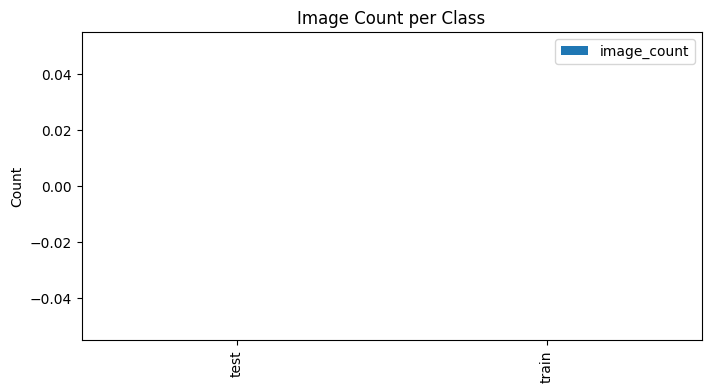

Copying test: 0it [00:00, ?it/s]


IndexError: list index out of range

In [8]:
# ===========================================================
# 🩻 Fragility Detection – Full End-to-End Notebook
# Includes: RGB Conversion + Preprocessing + Model Training
# ===========================================================

# -----------------------------
# Step 0: Imports
# -----------------------------
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


# ===========================================================
# Step 1️⃣: Ensure All Images are RGB (No Grayscale)
# ===========================================================
SRC = r"../Datasets/FragilityLevelDetection"

print("🔍 Checking and converting images to RGB format...")
for subdir, _, files in os.walk(SRC):
    for file in tqdm(files, desc=f"Processing {subdir}"):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(subdir, file)
            try:
                img = Image.open(path)
                if img.mode != "RGB":
                    img = img.convert("RGB")
                    img.save(path)
            except Exception as e:
                print("❌ Error on", path, e)
print("✅ All images verified as RGB.\n")


# ===========================================================
# Step 2️⃣: Dataset Check (Counts per Class)
# ===========================================================
print(f"📂 Checking dataset in: {SRC}\n")

class_counts = {}
for cls in os.listdir(SRC):
    cls_path = os.path.join(SRC, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        class_counts[cls] = count

df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['image_count'])
print(df)
df.plot(kind='bar', title="Image Count per Class", ylabel="Count", figsize=(8,4))
plt.show()


# ===========================================================
# Step 3️⃣: Preprocessing + Balancing (Augmentation)
# ===========================================================
OUT = r"../Datasets/processed/FragilityLevelDetection"
os.makedirs(OUT, exist_ok=True)

augment = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.1), p=0.5)
])

target_size = 300  # number of images per class
for cls in os.listdir(SRC):
    src_path = os.path.join(SRC, cls)
    dst_path = os.path.join(OUT, cls)
    os.makedirs(dst_path, exist_ok=True)

    imgs = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    for img_name in tqdm(imgs, desc=f"Copying {cls}"):
        img = cv2.imread(os.path.join(src_path, img_name))
        if img is None:
            continue
        img = cv2.resize(img, (224,224))
        cv2.imwrite(os.path.join(dst_path, img_name), img)

    # Augment to balance
    while len(os.listdir(dst_path)) < target_size:
        img_name = random.choice(imgs)
        img = cv2.imread(os.path.join(src_path, img_name))
        if img is None:
            continue
        img = cv2.resize(img, (224,224))
        aug = augment(image=img)['image']
        cv2.imwrite(os.path.join(dst_path, f"aug_{random.randint(0,999999)}.jpg"), aug)

print("\n✅ Balancing complete.")
counts = {cls: len(os.listdir(os.path.join(OUT, cls))) for cls in os.listdir(OUT)}
print(pd.DataFrame.from_dict(counts, orient='index', columns=['final_count']))


# ===========================================================
# Step 4️⃣: Data Generators
# ===========================================================
DATA_DIR = OUT
BATCH = 8
IMG = (224,224)
EPOCHS = 25

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

# Class weights
labels = train_gen.classes
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(labels), y=labels)))
print("\n✅ Class weights:", class_weights)


# ===========================================================
# Step 5️⃣: Model Definition (EfficientNetB0)
# ===========================================================
try:
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights='imagenet'
    )
    print("✅ Loaded EfficientNetB0 pretrained on ImageNet.")
except Exception as e:
    print("⚠️ Could not load pretrained weights, using random initialization.")
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights=None
    )

base.trainable = False
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.Dropout(0.6)(x)
out = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


# ===========================================================
# Step 6️⃣: Callbacks + Training
# ===========================================================
os.makedirs("../Models", exist_ok=True)
cp = ModelCheckpoint("../Models/fragility_best.keras", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=EPOCHS, class_weight=class_weights,
                    callbacks=[cp, es, rl])


# ===========================================================
# Step 7️⃣: Fine-Tune (Unfreeze last 50 layers)
# ===========================================================
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_gen, validation_data=val_gen,
                         epochs=10, class_weight=class_weights,
                         callbacks=[cp, es, rl])


# ===========================================================
# Step 8️⃣: Evaluation + Plots
# ===========================================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

print("\n💾 Model saved successfully as '../Models/fragility_best.keras'")


🔍 Checking and converting images to RGB format...


Processing ../Datasets/FragilityLevelDetection\train: 0it [00:00, ?it/s]
Processing ../Datasets/FragilityLevelDetection\train\Normal: 100%|█████████████████| 796/796 [00:00<00:00, 3158.75it/s]
Processing ../Datasets/FragilityLevelDetection\train\Osteopenia: 100%|█████████████| 796/796 [00:00<00:00, 4373.21it/s]
Processing ../Datasets/FragilityLevelDetection\train\Osteoporosis: 100%|███████████| 796/796 [00:00<00:00, 5237.56it/s]
Processing ../Datasets/FragilityLevelDetection\test: 0it [00:00, ?it/s]
Processing ../Datasets/FragilityLevelDetection\test\Normal: 100%|██████████████████| 453/453 [00:00<00:00, 4871.00it/s]
Processing ../Datasets/FragilityLevelDetection\test\Osteopenia: 100%|██████████████| 223/223 [00:00<00:00, 4847.90it/s]
Processing ../Datasets/FragilityLevelDetection\test\Osteoporosis: 100%|████████████| 471/471 [00:00<00:00, 4571.96it/s]


✅ All images verified as RGB.

                    image_count
train/Normal                796
train/Osteopenia            796
train/Osteoporosis          796
test/Normal                 453
test/Osteopenia             223
test/Osteoporosis           471


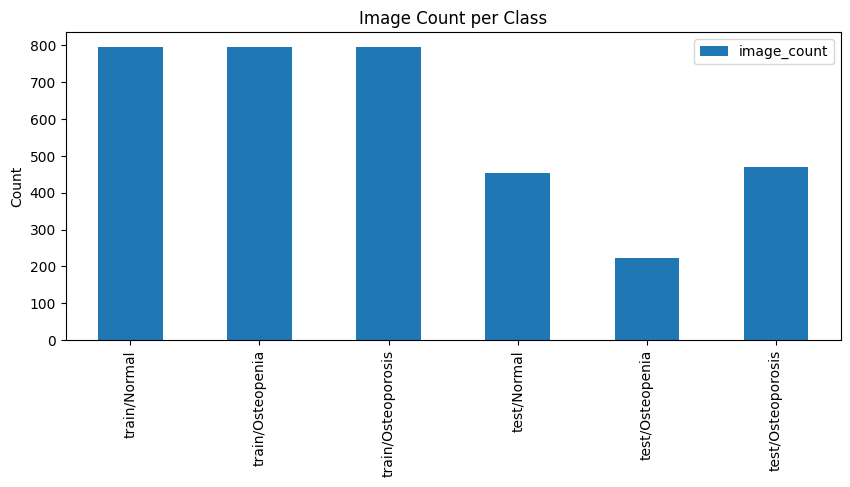

Copying test/Osteoporosis: 100%|█████████████████████████████████████████████████████| 471/471 [00:05<00:00, 87.89it/s]



✅ Balancing complete.
                    final_count
train/Normal                796
train/Osteopenia            796
train/Osteoporosis          796
test/Normal                 453
test/Osteopenia             400
test/Osteoporosis           471
Found 2388 images belonging to 3 classes.
Found 1324 images belonging to 3 classes.

✅ Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 29s 1us/step 
⚠️ Could not load pretrained weights, using random initialization.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 300, 300, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 300, 300, 3)       │               7 │ rescaling_5[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 301, 301, 3)       │               0 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 150, 150, 40)      │           1,080 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 150, 150, 40)      │             160 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 150, 150, 40)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 150, 150, 40)      │             360 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 150, 150, 40)      │             160 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 150, 150, 40)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 40)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 40)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 10)          │             410 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 40)          │             440 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 150, 150, 40)      │               

 Total params: 11,183,922 (42.66 MB)

 Trainable params: 397,315 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.3004 - loss: 1.7231  
Epoch 1: val_accuracy improved from None to 0.35574, saving model to ../Models/fragility_best.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 297s 962ms/step - accuracy: 0.3023 - loss: 1.5350 - val_accuracy: 0.3557 - val_loss: 1.2619 - learning_rate: 1.0000e-04
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3191 - loss: 1.2086  
Epoch 2: val_accuracy did not improve from 0.35574
299/299 ━━━━━━━━━━━━━━━━━━━━ 265s 887ms/step - accuracy: 0.3208 - loss: 1.1711 - val_accuracy: 0.3557 - val_loss: 1.1200 - learning_rate: 1.0000e-04
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.3373 - loss: 1.1120  
Epoch 3: val_accuracy did not improve from 0.35574
299/299 ━━━━━━━━━━━━━━━━━━━━ 265s 886ms/step - accuracy: 0.3283 - loss: 1.1069 - val_accuracy: 0.3557 - val_loss: 1.1004 - learning_rate: 1.0000e-04
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.3480 - loss: 

In [ ]:
# ===========================================================
# 🩻 Fragility Detection – Full Notebook
# Supports: train/ + test/ subfolders
# ===========================================================

# -----------------------------
# Step 0: Imports
# -----------------------------
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


# ===========================================================
# Step 1️⃣: Convert All Images to RGB (avoid grayscale mismatch)
# ===========================================================
SRC = r"../Datasets/FragilityLevelDetection"

print("🔍 Checking and converting images to RGB format...")
for split in ['train', 'test']:
    split_path = os.path.join(SRC, split)
    for subdir, _, files in os.walk(split_path):
        for file in tqdm(files, desc=f"Processing {subdir}"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(subdir, file)
                try:
                    img = Image.open(path)
                    if img.mode != "RGB":
                        img = img.convert("RGB")
                        img.save(path)
                except Exception as e:
                    print("❌ Error on", path, e)
print("✅ All images verified as RGB.\n")


# ===========================================================
# Step 2️⃣: Dataset Summary (Counts per Class)
# ===========================================================
class_counts = {}
for split in ['train', 'test']:
    split_path = os.path.join(SRC, split)
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))])
            class_counts[f"{split}/{cls}"] = count

df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['image_count'])
print(df)
df.plot(kind='bar', title="Image Count per Class", ylabel="Count", figsize=(10,4))
plt.show()


# ===========================================================
# Step 3️⃣: Preprocessing + Balancing (Augmentation)
# ===========================================================
OUT = r"../Datasets/processed/FragilityLevelDetection"
os.makedirs(OUT, exist_ok=True)

augment = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.1), p=0.5)
])

target_size = 400  # images per class
for split in ['train', 'test']:
    split_path = os.path.join(SRC, split)
    for cls in os.listdir(split_path):
        src_path = os.path.join(split_path, cls)
        dst_path = os.path.join(OUT, split, cls)
        os.makedirs(dst_path, exist_ok=True)

        imgs = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        for img_name in tqdm(imgs, desc=f"Copying {split}/{cls}"):
            img = cv2.imread(os.path.join(src_path, img_name))
            if img is None:
                continue
            img = cv2.resize(img, (224,224))
            cv2.imwrite(os.path.join(dst_path, img_name), img)

        # Augment to balance
        while len(os.listdir(dst_path)) < target_size:
            img_name = random.choice(imgs)
            img = cv2.imread(os.path.join(src_path, img_name))
            if img is None:
                continue
            img = cv2.resize(img, (224,224))
            aug = augment(image=img)['image']
            cv2.imwrite(os.path.join(dst_path, f"aug_{random.randint(0,999999)}.jpg"), aug)

print("\n✅ Balancing complete.")
counts = {}
for split in ['train', 'test']:
    split_path = os.path.join(OUT, split)
    for cls in os.listdir(split_path):
        counts[f"{split}/{cls}"] = len(os.listdir(os.path.join(split_path, cls)))
print(pd.DataFrame.from_dict(counts, orient='index', columns=['final_count']))


# ===========================================================
# Step 4️⃣: Data Generators
# ===========================================================
TRAIN_DIR = os.path.join(OUT, 'train')
TEST_DIR = os.path.join(OUT, 'test')

BATCH = 8
IMG = (300,300)
EPOCHS = 25

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical'
)

# Compute class weights
labels = train_gen.classes
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(labels), y=labels)))
print("\n✅ Class weights:", class_weights)


# ===========================================================
# Step 5️⃣: Model Definition (EfficientNetB0)
# ===========================================================
try:
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights='imagenet'
    )
    print("✅ Loaded EfficientNetB0 pretrained on ImageNet.")
except Exception as e:
    print("⚠️ Could not load pretrained weights, using random initialization.")
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights=None
    )

base.trainable = False
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.Dropout(0.6)(x)
out = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


# ===========================================================
# Step 6️⃣: Callbacks + Training
# ===========================================================
os.makedirs("../Models", exist_ok=True)
cp = ModelCheckpoint("../Models/fragility_best.keras", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=EPOCHS, class_weight=class_weights,
                    callbacks=[cp, es, rl])


# ===========================================================
# Step 7️⃣: Fine-Tuning (Unfreeze last 50 layers)
# ===========================================================
# -------------------------------
# Improved Fine-Tuning Phase
# -------------------------------
base.trainable = True
for layer in base.layers[:-120]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_more = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=[cp, es, rl]
)


# ===========================================================
# Step 8️⃣: Evaluation + Plots
# ===========================================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

print("\n💾 Model saved successfully as '../Models/fragility_best.keras'")


In [1]:
print(train_gen.class_indices)
print("Total train images:", train_gen.samples)
print("Total val images:", val_gen.samples)


NameError: name 'train_gen' is not defined

In [2]:
# ===========================================================
# Step 4️⃣: Data Generators
# ===========================================================
TRAIN_DIR = os.path.join(OUT, 'train')
TEST_DIR = os.path.join(OUT, 'test')

BATCH = 8
IMG = (300,300)
EPOCHS = 25

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG,
    batch_size=BATCH,
    class_mode='categorical'
)

# Compute class weights
labels = train_gen.classes
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(labels), y=labels)))
print("\n✅ Class weights:", class_weights)



NameError: name 'os' is not defined

In [ ]:
# ===========================================================
# Step 5️⃣: Model Definition (EfficientNetB0)
# ===========================================================
try:
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights='imagenet'
    )
    print("✅ Loaded EfficientNetB0 pretrained on ImageNet.")
except Exception as e:
    print("⚠️ Could not load pretrained weights, using random initialization.")
    base = tf.keras.applications.EfficientNetB0(
        input_shape=(IMG[0], IMG[1], 3),
        include_top=False,
        weights=None
    )

base.trainable = False
x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.Dropout(0.6)(x)
out = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


In [ ]:
# ===========================================================
# Step 6️⃣: Callbacks + Training
# ===========================================================
os.makedirs("../Models", exist_ok=True)
cp = ModelCheckpoint("../Models/fragility_best.keras", monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=EPOCHS, class_weight=class_weights,
                    callbacks=[cp, es, rl])

